# Build Financial Analysis From Scratch

In [192]:
import pandas as pd
import numpy as np
import io, os, sys,pickle
from datetime import datetime
import ipywidgets as widgets

import SelectInput
import Structured
import ParseTweet

In [218]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 88
import matplotlib.pyplot as plt

In [197]:
import importlib
importlib.reload(SelectInput)

<module 'SelectInput' from '/home/jovyan/projecthiro/SelectInput.py'>

In [198]:
importlib.reload(Structured)

<module 'Structured' from '/home/jovyan/projecthiro/Structured.py'>

## INTRODUCTION

Financial analyst and regulators often rely on the ratio analysis to investigate a company. For example, the current ratio has to be above a certain threshold to be considered liquid.

However, financial statements may not be available to invetors. This is not rare, especially among foreign companies and new comers. This notebook gives predicted current ratios based on
two types of input:

1. **Basic Information:**
    * Company Name
    * Address
    * Industry
    
2. **Twitter**

The method is scalable to produce other ratios in future. 

The rest of this notebook is arranged as follows:
1. Introduction
2. Method
3. Setup Model Input
    * setup input of basic information
    * setup input of tweets
4. Load the pre-trained Model
    * make predictions
    * plot the predicted current ratio from 2009Q4 to 2018Q4

## METHOD

** Model **

I use `y` to denote the current ratio of interest, `X` the basic information of the company, `Z` as information extracted from Twitter tweets. I train the model in two steps:

* First, I run a linear regression to get the mean estimator, $\hat{y}$.

$$ y = \beta X + \beta_0 + \varepsilon $$
$$ \hat{y} = \hat{\beta} X + \hat{\beta}_0 $$

* Second, I construct the residual of each observation to label the corresponding tweet,

$$ y-\hat{y} = f(Z) + \mu $$

* The combined estimator is $ \hat{y} + f(Z) $

** Training Data **

I construct current ratio, `y`, from over 80 million SEC financial statement filing entries, ranging from 2009 to 2019. The full dataset includes 36,136 SEC registered companies. The current ratio analysis takes a subset of all companies, which is around 10,000.

`X` is also from the above SEC filing data, `form sub`.

I use the [Twitter Scraper](https://github.com/jonbakerfish/TweetScraper) developed by `jonbakerfish` to scrape all historical top tweet of sample companies and group all tweets by post date. Each observation of `Z` contains all tweets from the quarter before the posting date of the corresponding quarterly current ratio. Tweets are transformed using `Hashing Vectorizer` before feeding to the estimator.

** Model Performance **

I use `Ridge` estimator from `sklearn` in both step. I also tried other `Linear Regressors` and `Ensemble Models`, which are either worse than or similar to `Ridge`.

The naive mean estimator has 0.26 cross validation $R^2$. The residual estimator using twitter tweets has 0.78 cross validation $R^2$, and the combined estimator has 0.8 cross validation $R^2$.
    

## SETUP MODEL INPUT

** Enter the name of the company **

In [82]:
company_name = SelectInput.company_name_widget() 

In [83]:
company_name # Please enter the name of the company

Text(value='', description='Name', placeholder='Zara Inc')

In [151]:
Company_Name = company_name.value
Company_Name

'Zara Inc'

** Enter the country **

Select the country origin of the company from the dropdown menu below. Select `Other` if you are not sure about it. The prediction is more accurate if you choose it correctly.

In [88]:
country_select = SelectInput.country_select_widget()

In [89]:
country_select

Select(description='Country:', index=92, options=('Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Bahamas', 'Barbados', 'Belgium', 'Belize', 'Bermuda', 'Brazil', 'Bulgaria', 'Cambodia', 'Canada', 'Cayman Islands', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Fiji', 'Finland', 'France', 'Georgia', 'Germany', 'Gibraltar', 'Greece', 'Grenada', 'Guam', 'Guatemala', 'Hong Kong', 'Hungary', 'India', 'Indonesia', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jersey', 'Jordan', 'Kazakhstan', 'Kenya', 'Korea, Republic of', 'Kyrgyzstan', 'Latvia', 'Lebanon', 'Lithuania', 'Luxembourg', 'Macao', 'Malaysia', 'Marshall Islands', 'Mexico', 'Moldova, Republic of', 'Monaco', 'Morocco', 'Netherlands', 'New Zealand', 'Norway', 'Other', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Romania', 'Russian Federation', 'Serbia', 'Singapore', 'Slovakia', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Taiwan, Province of China', 'Tanzania, United Republic of', 'Thailand', 'Turkey', 'Ukraine', 'United Arab Emirates', 'United Kingdom of Great Britain and Northern Ireland', 'United States of America', 'Uruguay', 'Viet Nam', 'Virgin Islands (British)', 'Virgin Islands (U.S.)'), value='United States of America')

In [137]:
countryba = SelectInput.country_dict[country_select.value]

In [138]:
countryba

'Other'

** Enter state if US or Canada **

If you are checking a US or Canada company, select the state of the company from the dropdown menu below.

In [139]:
state_select = SelectInput.state_select_widget(countryba)

In [140]:
state_select

In [141]:
if (countryba == 'US') | (countryba == 'CA'):
    stprba = state_select.value
else: stprba = '0'

In [142]:
stprba

'0'

** Enter the industry code **

Select the division and industry of the company from the dropdown menu below. Select `Other` if you are not sure about it. The prediction is more accurate if you choose it correctly.

In [100]:
division_select = SelectInput.division_select_widget()

In [101]:
division_select

Select(description='Division', index=3, options=('Agriculture, Forestry, and Fishing', 'Construction', 'Finance, Insurance, and Real Estate', 'Manufacturing', 'Mining', 'Nonclassifiable Establishments', 'Retail Trade', 'Services', 'Transportation, Communications, Electric, Gas, and Sanitary Services', 'Wholesale Trade'), value='Manufacturing')

In [105]:
div = division_select.value
industry_select = SelectInput.industry_select_widget(div)

In [106]:
industry_select

Select(description='Industry', options=('CONSTRUCTION - SPECIAL TRADE CONTRACTORS', 'ELECTRICAL WORK', 'GENERAL BLDG CONTRACTORS - NONRESIDENTIAL BLDGS', 'GENERAL BLDG CONTRACTORS - RESIDENTIAL BLDGS', 'HEAVY CONSTRUCTION OTHER THAN BLDG CONST - CONTRACTORS', 'OPERATIVE BUILDERS', 'WATER, SEWER, PIPELINE, COMM & POWER LINE CONSTRUCTION'), value='CONSTRUCTION - SPECIAL TRADE CONTRACTORS')

In [107]:
sic = SelectInput.sic_reg[SelectInput.sic_reg['industry']==industry_select.value]['sic'].values[0]



In [108]:
sic

'1540'

** Select size of the company **

In [109]:
afs_select = SelectInput.afs_select_widget()

In [110]:
afs_select

Select(description='Size', options=('afs_1-LAF', 'afs_2-ACC', 'afs_3-SRA', 'afs_4-NON', 'afs_5-SML'), value='afs_1-LAF')

In [143]:
afs = afs_select.value

In [144]:
afs

'afs_1-LAF'

** Get Structured Data **

Put all five types of structured data together in `test`:
1. sic_
2. t_2009q4 to t_2019q4
3. countryba_
4. stprba_
5. afs_

In [199]:
test_X = Structured.getX(sic,countryba,stprba,afs)

** Get Tweets **

Use TweetScraper to search top tweet related to the Company of interest. 

In [152]:
with open('get_tweet.sh','w') as f:
    f.write('#!/bin/bash\n')
    f.write('scrapy crawl TweetScraper -a query="'+Company_Name+'"'+' -a top_tweet=True')

In [ ]:
! ./get_tweet.sh

In [ ]:
tweet_df = ParseTweet.get_text()

## LOAD MODEL

In [194]:
with open('ridgemodel.pickle','rb') as f:
    ridgemodel = pickle.load(f)

The following cell generates naive mean estimator.

In [200]:
y_hat = ridgemodel.predict(test_X)

In [3]:
with open('sentimentmodel.pickle','rb') as f:
    sentiment = pickle.load(f)

In [ ]:
res = sentiment.predict(tweet_df['text'])

The following cell generates the combined estimator on the Current Ratio from 2009Q4 to 2018Q4. Some companies do not have related twitter posting during certain quarters, the combined estimator will equal to the mean estimator during these periods. 

In [ ]:
current_ratio = y_hat + res

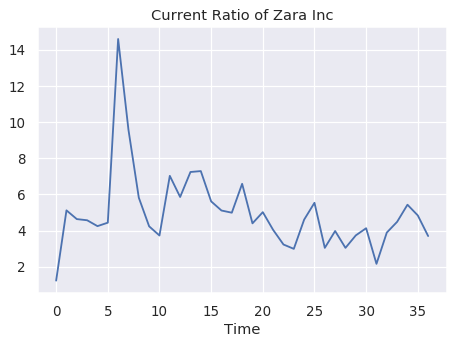

In [222]:
plt.title("Current Ratio of "+ Company_Name)

plt.plot(y_hat,label = 'Mean Estimator')
plt.plot(current_ratio,label = 'Adjusted Estimator')
plt.xlabel('Time');